In [1]:
!nvidia-smi

Thu May 23 10:29:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import requests
from pathlib import Path
from timeit import default_timer as timer
from tqdm.auto import tqdm
import pandas as pd
import random

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
"""
0. Computer vision libraries in PyTorch
* torchvision - base domain library for Pytorch computer vision
* torchvision.datasets - gets datasets and data loading functions for computer vision
* torchvision.models - get pretrained computer vision models that you can leverage for your own problems
* torchvision.transforms - functions for manipulating your vision data (images) to be suitable for use with an ML model
* torch.utils.data.Dataset - base dataset class for pytorch
* torch.utils.data.Dataloader - creates a python iterable over a dataset



1. Getting a dataset
The dataset we'll be using is FashionMNIST from torchvision.datasets
"""
# Setup training data
train_data = datasets.FashionMNIST(
    root='/home/michel/Desktop/TopNetwork/08: PyTorch/PYTORCH_NOTEBOOKS/Data', # where to download data to?
    train=True, # do we want the training set?
    download=True, # do we want to download yes/no?
    transform=torchvision.transforms.ToTensor(), # how do we want to transform the data?
    target_transform=None) # how do we want to transform the labels/targets?

test_data = datasets.FashionMNIST(
root='/home/michel/Desktop/TopNetwork/08: PyTorch/PYTORCH_NOTEBOOKS/Data',
    train=False, # do we want the test set?
    download=True,
    transform=ToTensor(),
    target_transform=None)

print(len(train_data), len(test_data))
# See the first training example
image, label = train_data[0]
print(image, label)
class_names = train_data.classes
print(class_names)
class_to_idx = train_data.class_to_idx
print(class_to_idx)
print(train_data.targets)

100%|██████████| 26421880/26421880 [00:01<00:00, 13645481.63it/s]


Extracting /home/michel/Desktop/TopNetwork/08: PyTorch/PYTORCH_NOTEBOOKS/Data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /home/michel/Desktop/TopNetwork/08: PyTorch/PYTORCH_NOTEBOOKS/Data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 204162.05it/s]


Extracting /home/michel/Desktop/TopNetwork/08: PyTorch/PYTORCH_NOTEBOOKS/Data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /home/michel/Desktop/TopNetwork/08: PyTorch/PYTORCH_NOTEBOOKS/Data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3735030.81it/s]


Extracting /home/michel/Desktop/TopNetwork/08: PyTorch/PYTORCH_NOTEBOOKS/Data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /home/michel/Desktop/TopNetwork/08: PyTorch/PYTORCH_NOTEBOOKS/Data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21484852.73it/s]

Extracting /home/michel/Desktop/TopNetwork/08: PyTorch/PYTORCH_NOTEBOOKS/Data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /home/michel/Desktop/TopNetwork/08: PyTorch/PYTORCH_NOTEBOOKS/Data/FashionMNIST/raw

60000 10000
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0

In [4]:
"""
1.1 Check input and output shapes of data
"""
print(f'\nImage shape: {image.shape} -> [color channels, height, widht]')
print(f'Image label: {class_names[label]}')

"""
1.2 Visualizing our data
"""
# plt.imshow(image.squeeze())
# plt.title(f'{label} - {class_names[label]}')
# plt.show()

# plt.imshow(image.squeeze(), cmap='gray')
# plt.title(f'{label} - {class_names[label]}')
# plt.axis(False)
# plt.show()

# Plot more images
# torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    # fig.add_subplot(rows, cols, i)
    # plt.imshow(img.squeeze(), cmap='gray')
    # plt.title(f'{label} - {class_names[label]}')
    # plt.axis(False)
# plt.show()
#  Now... we need a model with linearity or also with non-linearity?



Image shape: torch.Size([1, 28, 28]) -> [color channels, height, widht]
Image label: Ankle boot


<Figure size 900x900 with 0 Axes>

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /home/michel/Desktop/TopNetwork/08: PyTorch/PYTORCH_NOTEBOOKS/Data
    Split: Train
    StandardTransform
Transform: ToTensor() Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: /home/michel/Desktop/TopNetwork/08: PyTorch/PYTORCH_NOTEBOOKS/Data
    Split: Test
    StandardTransform
Transform: ToTensor()
<torch.utils.data.dataloader.DataLoader object at 0x7fe28a38f040> <torch.utils.data.dataloader.DataLoader object at 0x7fe1a84fa980>
Lenght of train_dataloader: 1875 batches of 32...
Lenght of test_dataloader: 313 batches of 32...
Image size: torch.Size([1, 28, 28])
Label: 0, label size: torch.Size([])


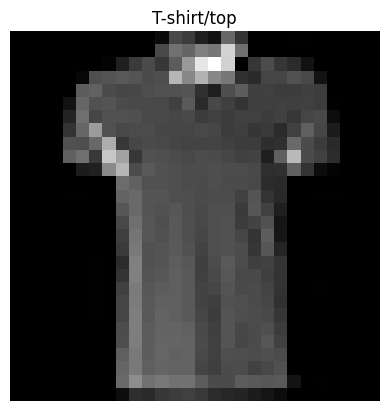

In [5]:
"""
2. Prepare DataLoader
Right now, our data is in form of Pytorch datasets.
Dataloader turns our dataset into a python iterable
More specifically we want to turn our data into batches (or mini-batches)
Why?
1. It's more computationally efficient, your computer could not store in memory
all 60000 images in one hit, so we break it down (in this case batch size of 32 at time)
2. It gives our neural network more chances to update its gradients per epoch
"""
print(train_data, test_data)
# Setup the batch size hyperparameter
BATCH_SIZE = 32
# Turn datasets into iterables (batches)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)
print(train_dataloader, test_dataloader)
# Let's check out what we've created
print(f'Lenght of train_dataloader: {len(train_dataloader)} '
      f'batches of {BATCH_SIZE}...')
print(f'Lenght of test_dataloader: {len(test_dataloader)} '
      f'batches of {BATCH_SIZE}...')
# Now lets checkout what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
test_features_batch, test_labels_batch = next(iter(test_dataloader))
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis(False)
print(f'Image size: {img.shape}')
print(f'Label: {label}, label size: {label.shape}')
# plt.show()

In [6]:
"""
3. Model 0: Build a basline model
When starting to build a series of machine learning modelling experiments,
it's best practice to start with a baseline model
A baseline model is a simple model you will try and improve upon with
subsequent models/experiments
In other words: start simply and add complexity when necessary.
"""
# Create a flatten layer
flatten_model = nn.Flatten()
# Get a single sample
x = train_features_batch[0]
# Flatten the sample
output = flatten_model(x) # perform forward pass
# We get a singole vector of values if we squeeze the result
print(f'Shape before flattening: {x.shape}') # torch.Size([1, 28, 28])
print(f'Shape after flattening: {output.shape}') # torch.Size([1, 784]
class FashionMNISTModelV0(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # we don't want shape mismatches, so we set a vector
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape))

    def forward(self, x):
        return self.layer_stack(x)

torch.manual_seed(42)
# Setup model with input parameters
model_0 = FashionMNISTModelV0(
    input_shape=784, # like the flattened vector: 28x28
    hidden_units=10, # how many neurons in the hidden layers
    output_shape=len(class_names)).to(device) # one for every class of the dataset
print(model_0)
dummy_x = torch.rand([1, 1, 28, 28]).to(device)
print(model_0(dummy_x))
print(model_0(dummy_x).shape) # we want one logit per class

Shape before flattening: torch.Size([1, 28, 28])
Shape after flattening: torch.Size([1, 784])
FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)
tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], device='cuda:0', grad_fn=<AddmmBackward0>)
torch.Size([1, 10])


In [7]:
"""
3.1 Setup loss, optimizer and evaluation metrics
* Loss function - since we're working with multi-class data,
our loss function will be nn.CrossEntropyLoss()
* Optimizer - our optimizer torch.optim.SGD()
* Evaluation metric -
"""
# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path('helper_functions.py').is_file():
    print('helper_functions.py already exists, skipping download')
else:
    print('Downloading helper_functions.py')
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open('helper_functions.py', 'wb') as f:
        f.write(request.content)
# Import accuracy metric
from helper_functions import accuracy_fn
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

"""
3.2 Creating a function to time our experience
Machine learning is very experimental
Two main things you'll often want to track are:
1. Model performance (loss and accuracy)
2. How fast it runs
"""
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    """Prints difference between start and end time"""
    total_time = end - start
    print(f'Train time on {device} took: {total_time:.3f} seconds')
    return total_time
start_time = timer()
end_time = timer()
print_train_time(start=start_time, end=end_time, device="cpu")

Train time on cpu took: 0.000 seconds


3.086600003143758e-05

In [8]:
"""
3.3 Creatiing a training loop and training a model on batches of data
1. Loop through epochs
2. Loop through training batches, perform training steps, calculate the train lossà
3. Loop through testing batches, perform testing steps, calculate the test loss
4. Print our what's happening
5. Time it all
"""
# Import tqdm for seeing progress bars, set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()
# Set the number of epochs (we'll keep this small for faster training time)
epochs = 3
# Create training and test loop
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\r------')
    # Training
    train_loss = 0
    # Add a loop to through the training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        # Make our data device agnostic
        X, y = X.to(device), y.to(device)
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulate train loss

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5.Optimizer step
        optimizer.step()

        # Print out what's happening
        if batch % 400 == 0:
            print(f'Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples')

    # Divide total train loss by lenght of train dataloader
    train_loss /= len(train_dataloader)

    # Testing
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
          # Make our data device agnostic
            X_test, y_test = X_test.to(device), y_test.to(device)
            # 1. Forward pass
            test_pred = model_0(X_test)

            # 2. Calculate loss (accumulatively)
            test_loss += loss_fn(test_pred, y_test)

            # 3. Calculate accuracy
            test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

        # Calculate the test loss avarage per batch
        test_loss /= len(test_dataloader)

        # Calculate the test acc avarage per batch
        test_acc /= len(test_dataloader)

    # Print out what's happening
    print(f'\nTrain loss: {train_loss:.4f} | '
          f'Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}%')

# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))


  0%|          | 0/3 [00:00<?, ?it/s]

------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.5904 | Test loss: 0.5095, Test acc: 82.0387%
------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.4763 | Test loss: 0.4799, Test acc: 83.1969%
------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.4550 | Test loss: 0.4766, Test acc: 83.4265%
Train time on cuda:0 took: 29.871 seconds


In [9]:
"""
4. Make predictions and get Model 0 results
"""
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device=device):
    """Returns a dictionary containing the results
    of model predicting on data loader"""
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make our data device agnostic
            X, y = X.to(device), y.to(device)
            # Make predictions
            y_pred = model(X)

            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                               y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc to find the avarage loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {'Model name': model.__class__.__name__, # only works when model was created with a class, returns class name
            'Model loss': loss.item(),
            'Model acc': acc}

# Calculate model 0 results on test dataset
model_0_result = eval_model(model=model_0,
                            data_loader=test_dataloader,
                            loss_fn=loss_fn,
                            accuracy_fn=accuracy_fn,
                            device=device)
print(model_0_result)

{'Model name': 'FashionMNISTModelV0', 'Model loss': 0.47663894295692444, 'Model acc': 83.42651757188499}


In [10]:
"""
6. Model 1: Building a better model with non-linearity
CHECK IF USING A GPU WITH GOOGLE COLAB IS FASTER
"""
# Create a model with non-linear and linear layers
class FashionMNISTModelV1(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # we don't want shape mismatches, so we set a vector
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape),
            nn.ReLU())

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

"""
6.1 Setup loss, optimizer and evaluation metrics
"""
loss_fn = nn.CrossEntropyLoss() # measure how wrong our model is
optimizer = torch.optim.SGD(params=model_1.parameters(), # tries to update our model's parameters to reduce the loss
                            lr=0.1)

In [11]:
"""
6.2 Functionizing training and evaluation/testing loops
Let's create a function for:
* training loop - train_step()
* testing loop - test_step()
"""
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    """Performs a training with model trying to learn on data_loader"""
    train_loss, train_acc = 0, 0
    # Put the model into training mode
    model.train()
    # Add a loop to through the training batches
    for batch, (X, y) in enumerate(data_loader):
        # Put data on target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass (outputs the raw logits from the model)
        y_pred = model(X)

        # 2. Calculate loss and accuracy (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulate train loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # from logits to prediction labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5.Optimizer step
        optimizer.step()

    # Divide total train loss and acc by lenght of train dataloader
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f'Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%')

def test_step(model: torch.nn.Module,
             data_loader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             accuracy_fn,
             device: torch.device = device):
    """Performs a testing loop step on model going over data_loader"""
    test_loss, test_acc = 0, 0
    # Put the model in eval mode
    model.eval()
    # Turn on inference mode context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send the data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate the loss/acc
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                                    y_pred=test_pred.argmax(dim=1)) # from logits to prediction labels

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f'Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n')

torch.manual_seed(42)
# Measure time
train_time_start_on_gpu = timer()
# Set epochs
epochs = 3
# Create an optimization and evaluation loop using
# train_step() and test_step()
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n------')
    train_step(model=model_1,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    test_step(model=model_1,
               data_loader=test_dataloader,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               device=device)

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(train_time_start_on_gpu,
                                            train_time_end_on_gpu,
                                            device)
print(model_0_result, total_train_time_model_0)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Train loss: 1.09199 | Train acc: 61.34%
Test loss: 0.95636 | Test acc: 65.00%

Epoch: 1
------
Train loss: 0.78101 | Train acc: 71.93%
Test loss: 0.72227 | Test acc: 73.91%

Epoch: 2
------
Train loss: 0.67027 | Train acc: 75.94%
Test loss: 0.68500 | Test acc: 75.02%

Train time on cuda took: 30.157 seconds
{'Model name': 'FashionMNISTModelV0', 'Model loss': 0.47663894295692444, 'Model acc': 83.42651757188499} 29.870870911999987


In [12]:
"""
Sometimes depending on your data/hardware you might find that
your model trains faster on CPU than GPU
Why is this?
1. It could be that overhead for copying data/model to and from the GPU
weights the compute benefits offered by the GPU
2. The hardware you're using has a better CPU in terms of compute capability
than the GPU
For more see here: https://horace.io/brrr_intro.html
"""
# Get model_1 results dictionary
model_1_result = eval_model(model=model_1,
                            data_loader=test_dataloader,
                            loss_fn=loss_fn,
                            accuracy_fn=accuracy_fn,
                            device=device)
print(model_1_result, total_train_time_model_1)

{'Model name': 'FashionMNISTModelV1', 'Model loss': 0.6850008964538574, 'Model acc': 75.01996805111821} 30.15740402800003


torch.Size([1, 28, 28])


tensor([[ 0.0366, -0.0940,  0.0686, -0.0485,  0.0068,  0.0290,  0.0132,  0.0084,
         -0.0030, -0.0185]], device='cuda:0', grad_fn=<AddmmBackward0>)

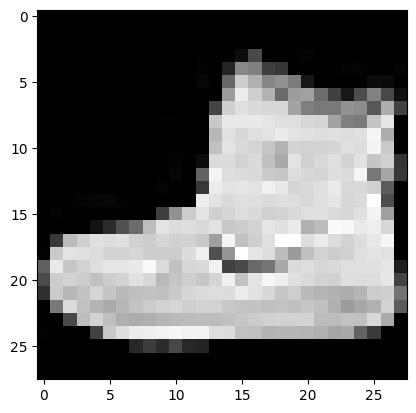

In [13]:
"""
Model 2: Building a Convolutional Neural Network (CNN)
CNN's are also known has ConvNets
CNN's are known for their capabilities to find patterns in visual data
For see how a CNN works: https://poloclub.github.io/cnn-explainer/
"""
# Create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture that replicates the TinyVGG
    model from CNN explainer website
    """
    def __init__(self, input_shape:int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        #  Create a convolutional block
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, # images = 2d data
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1), # hyperparameters
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, # there is a trick to calculate this
                      out_features=output_shape))

    def forward(self, x):
        x = self.conv_block_1(x)
        # print(f'Output shape of conv_block_1: {x.shape}')
        x = self.conv_block_2(x)
        # print(f'Output shape of conv_block_2: {x.shape}') # see the shape for the in feature in classifier
        x = self.classifier(x)
        # print(f'Output shape of classifier: {x.shape}')
        return x

torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, # color channel
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)
plt.imshow(image.squeeze(), cmap='gray')
rand_image_tensor = torch.randn(1, 28, 28)
print(rand_image_tensor.shape)
# model_2(rand_image_tensor) -> shape mismatch
model_2(rand_image_tensor.unsqueeze(0).to(device))


# Pass image through model
# model_2(image) -> shape mismatch

In [14]:
"""
7.1 Stepping through nn.Conv2d
"""
torch.manual_seed(42)
# Create a batch of images
images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]
print(f'Image batch shape: {images.shape}')
print(f'Single image shape: {test_image.shape}')
print(f'Test image:\n {test_image}')
# Create a single conv2d layer
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=(3, 3),
                       stride=1,
                       padding=0)
conv_output = conv_layer(test_image.unsqueeze(0))
print(conv_output.shape)

"""
7.2 Stepping through nn.MaxPool2d()
"""
# Print out original image shape without unsqueezed dimension
print(f'Test image original shape: {test_image.shape}')
print(f'Test image with unsueezed dimension: {test_image.unsqueeze(0).shape}')
# Create a sample nn.MaxPool2d layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)
# Pass data through just the conv_layer
test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f'Shape after going through conv_layer(): {test_image_through_conv.shape}')
# Pass data through the max pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f'Shape after going through conv and max_pool layer: {test_image_through_conv_and_max_pool.shape}')
torch.manual_seed(42)
# Create a random vector with a similar number of dimensions to our images
random_tensor = torch.randn(size=(1, 1, 2, 2))
print(f'\nRandom tensor:\n{random_tensor}')
print(f'Random tensor shape: {random_tensor.shape}')
print(random_tensor)
# Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)
# Pass the random tensor to the max pool layer
max_pool_tensor = max_pool_layer(random_tensor)
print(f'\nMax pool tensor:\n{max_pool_tensor}')
print(f'Max pool tensor shape: {max_pool_tensor.shape}')

Image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])
Test image:
 tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0

In [15]:
"""
7.3 Setup a loss function and optimizer for model_2
"""
# Setup loss function/eval metrics/optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

"""
7.4 Training and testing model_2 using our training and test functions
"""
torch.manual_seed(42)
torch.cuda.manual_seed(42)
# Measure time
train_time_start_model_2 = timer()
# Train and test model
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n------')
    train_step(model=model_2,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    test_step(model=model_2,
               data_loader=test_dataloader,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               device=device)

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(train_time_start_model_2,
                                            train_time_end_model_2,
                                            device)
# Get model_2 results
model_2_result = eval_model(model=model_2,
                            data_loader=test_dataloader,
                            loss_fn=loss_fn,
                            accuracy_fn=accuracy_fn,
                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Train loss: 0.59896 | Train acc: 78.30%
Test loss: 0.39569 | Test acc: 85.76%

Epoch: 1
------
Train loss: 0.36117 | Train acc: 86.93%
Test loss: 0.36358 | Test acc: 86.81%

Epoch: 2
------
Train loss: 0.32332 | Train acc: 88.35%
Test loss: 0.32792 | Test acc: 88.13%

Train time on cuda took: 38.037 seconds


            Model name  Model loss  Model acc  training time
0  FashionMNISTModelV0    0.476639  83.426518      29.870871
1  FashionMNISTModelV1    0.685001  75.019968      30.157404
2  FashionMNISTModelV2    0.327919  88.128994      38.037351


Text(0, 0.5, 'model')

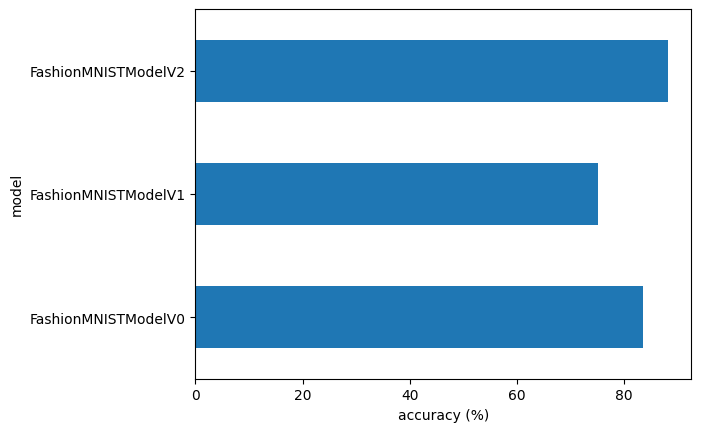

In [16]:
"""
8. Compare model results and trainig time
"""
compare_results = pd.DataFrame([model_0_result,
                               model_1_result,
                               model_2_result])
# Add training time to results comparison
compare_results['training time'] = [total_train_time_model_0,
                                    total_train_time_model_1, # with a gpu this one is slower
                                    total_train_time_model_2] # with a gpu this one is faster
print(compare_results)
"""
Computer:
Model name  Model loss  Model acc  training time
0  FashionMNISTModelV0    0.476639  83.426518      15.582225
1  FashionMNISTModelV1    0.685001  75.019968      18.475133
2  FashionMNISTModelV2    0.320499  88.398562      48.018168

Google colab gpu:
Model name  Model loss  Model acc  training time
0  FashionMNISTModelV0    0.471430  83.576278      30.282343
1  FashionMNISTModelV1    0.685001  75.019968      31.532655
2  FashionMNISTModelV2    0.320560  88.238818      37.961074
"""
# Visualize our model results
compare_results.set_index('Model name')['Model acc'].plot(kind='barh')
plt.xlabel('accuracy (%)')
plt.ylabel('model')
# plt.show()


torch.Size([1, 28, 28])
tensor([[7.3540e-07, 1.0816e-06, 8.4697e-06, 1.4397e-06, 4.2176e-06, 6.7065e-04,
         2.9937e-05, 5.0094e-05, 1.0353e-04, 9.9913e-01],
        [7.5713e-03, 8.9813e-05, 2.2380e-05, 9.9121e-01, 7.9453e-05, 9.1571e-07,
         9.9399e-04, 1.9958e-05, 1.5236e-05, 1.0689e-06]])
tensor([9, 3, 4, 3, 0, 8, 9, 9, 5])


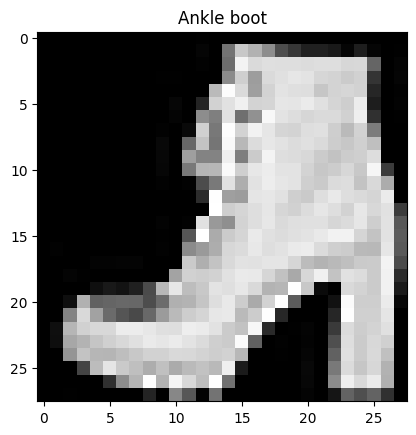

In [17]:
"""
9. Model and evaluate random predictions with best model
"""
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward pass (model outputs raw logits)
      pred_logits = model(sample)

      # Get prediction probability (logit -> prediction probability)
      pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)

      # Get pred_prob off the GPU for further calculations
      pred_probs.append(pred_prob.cpu())

  # Stack the pred_probs to turn list into tensor
  return torch.stack(pred_probs)

# random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

# View the first sample shape
print(test_samples[0].shape)
plt.imshow(test_samples[0].squeeze(), cmap='gray')
plt.title(class_names[test_labels[0]])
# plt.show()
# Make predictions
pred_probs = make_predictions(model=model_2,
                              data=test_samples)
# View first two prediction probabilies
print(pred_probs[:2])
# Convert prediction probabilities to labels
pred_classes = pred_probs.argmax(dim=1)
print(pred_classes)

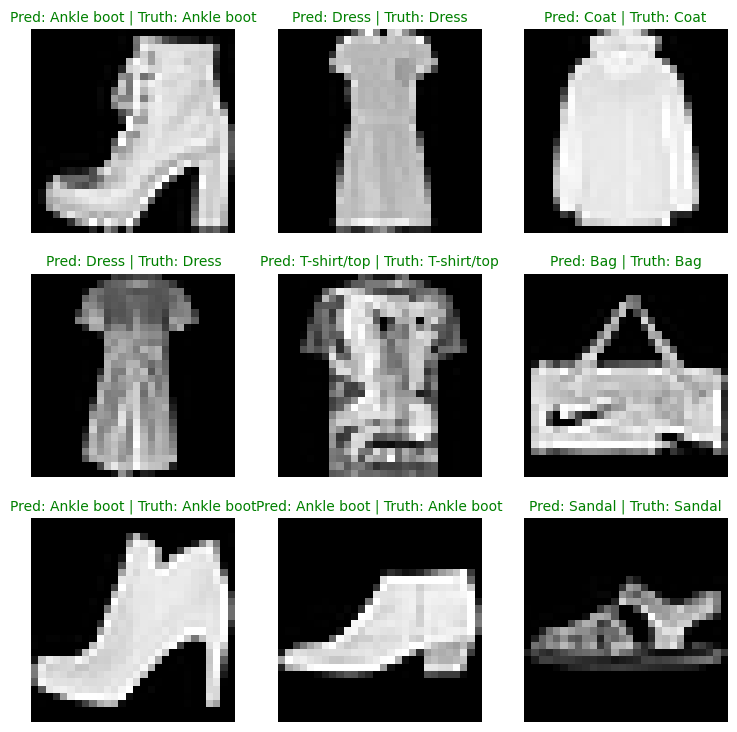

In [18]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    # Create a subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    plt.imshow(sample.squeeze(), cmap='gray')

    # Find the prediction (in text form, e.g "Sandal")
    pred_label = class_names[pred_classes[i]]

    # Get the truth label (in text form)
    truth_label = class_names[test_labels[i]]

    # Create a title for the plot
    title_text = f'Pred: {pred_label} | Truth: {truth_label}'

    # Check for equality between pred and truth and change color of title text
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c='g') # green text if prediction same as truth
    else:
        plt.title(title_text, fontsize=10, c='r')
    plt.axis(False)

In [20]:
"""
10. Making a confusion matrix for further prediction evaluation
A confusion matrix is a fantastic way of evaluating your classification models visually
1. Make predictions with our trained model on the test dataset
2. Make a confusion matrix torchmetrics.ConfusionMatrix
3. Plot the confusion matrix using mlxtend.plotting.plot_confusion_matrix()
"""
# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc='Making predictions...'):
        # Send the data and targets to target device
        X, y = X.to(device), y.to(device)
        # Do the forward pass
        y_logit = model_2(X)
        # Turn predictions from logits -> prediction probabilities -> prediction labels
        y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
        # Put prediction on CPU for evaluation
        y_preds.append(y_pred.cpu())

    # Concatenate list of predictions into a tensor
    # print(y_preds)
    y_pred_tensor = torch.cat(y_preds)
    print(y_pred_tensor, len(y_pred_tensor))

# See if required packages are installed, and if not install them
try:
    import torchmetrics, mlxtend
    print(f'mltxtend version: {mlxtend.__version__}')
    assert int(mlxtend.___version__.split('.')[1]) >= 19, 'mlxtend version should be 0.19.9 or higher'
except:
    !pip install torchmetrics -U mlxtend
    import torchmetrics, mlxtend
    print(f'mltxtend version: {mlxtend.__version__}')

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1,  ..., 8, 1, 8]) 10000
mltxtend version: 0.23.1
mltxtend version: 0.23.1


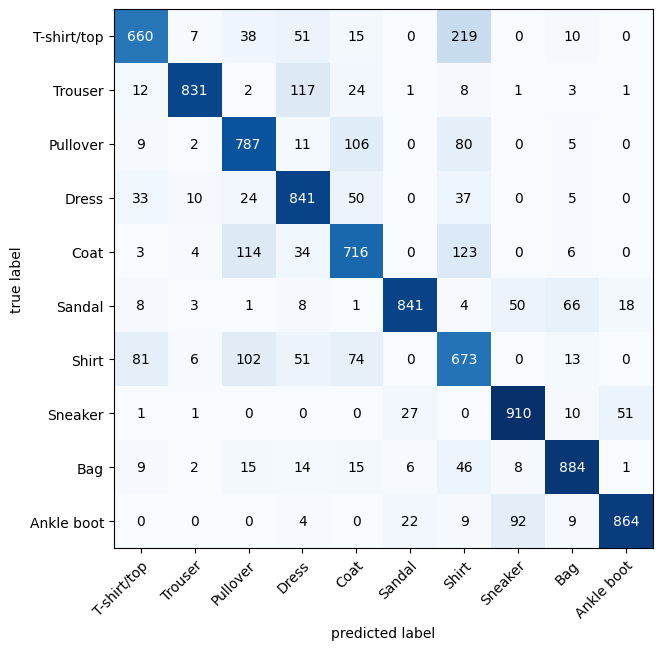

In [22]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2.  Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names),
                          task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)
# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), # matplotlib likes numpy
                                class_names=class_names,
                                figsize=(10, 7))
# plt.show()

In [31]:
"""
11. Save and load best performing model
"""
# Create model directory path
MODEL_PATH = Path('/home/michel/models')
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)
# Create model save
MODEL_NAME = 'computer_vision_model_2.pt'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f'Saving model to: {MODEL_SAVE_PATH}')
torch.save(obj=model_2.state_dict(),
           f=MODEL_SAVE_PATH)

# Create a new instance
torch.manual_seed(42)
loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                                     hidden_units=10,
                                     output_shape=len(class_names))
# Load in the save state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
# Send the model to the target device
loaded_model_2.to(device)

# Evaluate loaded model
print(model_2_result)
torch.manual_seed(42)
loaded_model_2_result = eval_model(model=loaded_model_2,
                                 data_loader=test_dataloader,
                                 loss_fn=loss_fn,
                                 accuracy_fn=accuracy_fn)
print(loaded_model_2_result)
# Check if model results are close to each other
torch.isclose(torch.tensor(model_2_result['Model loss']),
              torch.tensor(loaded_model_2_result['Model loss']),
              atol=1e-02) # we put a margin of error

Saving model to: /home/michel/models/computer_vision_model_2.pt
{'Model name': 'FashionMNISTModelV2', 'Model loss': 0.3279189169406891, 'Model acc': 88.12899361022365}
{'Model name': 'FashionMNISTModelV2', 'Model loss': 0.3279189169406891, 'Model acc': 88.12899361022365}


tensor(True)